# Nixtla and StatsForecast — End to End Walkthrough

This walkthrough comes from the Nixtla documentation on StatsForecast here: https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_complete.html

Model training, evaluation, and selection for multiple time series using StatsForecast.

Prerequisites: this guide assumes basic familiarity with StatsForecast. For a minimal example visit the Quick Start.
Follow this article for a step-by-step guide on building a production-ready forecasting pipeline for multiple time series.
During this guide you will gain familiarity with the core `StatsForecast` class and methods such as `StatsForecast.plot`, `StatsForecast.forecast`, and `StatsForecast.cross_validation`.
We will use a classical benchmarking dataset from the M4 competition. The dataset includes time series from different domains like finance, economy, and sales. In this example, we use a subset of the Hourly dataset.
We will model each time series individually. Forecasting at this level is also known as local forecasting. Therefore, you will train a series of models for every unique series and then select the best one. StatsForecast focuses on speed, simplicity, and scalability, which makes it ideal for this task.

Outline:

- Install packages.
- Read the data.
- Explore the data.
- Train many models for every unique combination of time series.
- Evaluate the model's performance using cross-validation.
- Select the best model for every unique time series.

Not covered in this guide:

- Forecasting at scale using clusters on the cloud.
- Forecast the M5 Dataset in five minutes using Ray clusters.
- Forecast the M5 Dataset in five minutes using Spark clusters.
- Learn how to predict one million series in less than 30 minutes.
- Training models on multiple seasonalities (see the electricity load forecasting tutorial).
- Using external regressors or exogenous variables (follow the exogenous variables tutorial).
- Comparing StatsForecast with other popular libraries (benchmarks available in the documentation).

## Install Libraries

We assume you have StatsForecast already installed. Check the official installation guide if you need to add it to your environment.

## Read the Data

Use pandas to read the M4 Hourly dataset stored in a parquet file for efficiency. You can use ordinary pandas operations to read your data in other formats like CSV.

The input to StatsForecast is always a data frame in long format with three columns: `unique_id`, `ds`, and `y`.

- `unique_id` (string, int, or category) represents an identifier for the series.
- `ds` (datestamp or int) should be either an integer indexing time or a timestamp (for example `YYYY-MM-DD` or `YYYY-MM-DD HH:MM:SS`).
- `y` (numeric) represents the measurement we wish to forecast. Rename the target column to `y` if it differs in your source data.

This dataset already satisfies the requirements. Depending on your internet connection, this step should take around 10 seconds.

In [1]:
import pandas as pd

In [2]:
Y_df = pd.read_parquet("https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet")
Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


This dataset contains 414 unique series with 900 observations on average. For this example and reproducibility's sake, select only 10 unique IDs and keep only the last week. Depending on your processing infrastructure feel free to select more or fewer series.

Processing time depends on the available computing resources. Running the complete dataset takes around 10 minutes on an AWS c5d.24xlarge (96 cores) instance.

In [3]:
uids = Y_df["unique_id"].unique()[:10]
Y_df = Y_df.query("unique_id in @uids")
Y_df = Y_df.groupby("unique_id").tail(7 * 24)
Y_df.head()

,unique_id,ds,y
580,H1,581,587.0
581,H1,582,537.0
582,H1,583,492.0
583,H1,584,464.0
584,H1,585,443.0


## Explore Data with the Plot Method

Plot some series using the `StatsForecast.plot` method. This method prints eight random series from the dataset and is useful for basic exploratory data analysis.

Note: `StatsForecast.plot` uses Plotly as the default engine. You can change to Matplotlib by setting `engine="matplotlib"`.

In [4]:
from statsforecast import StatsForecast

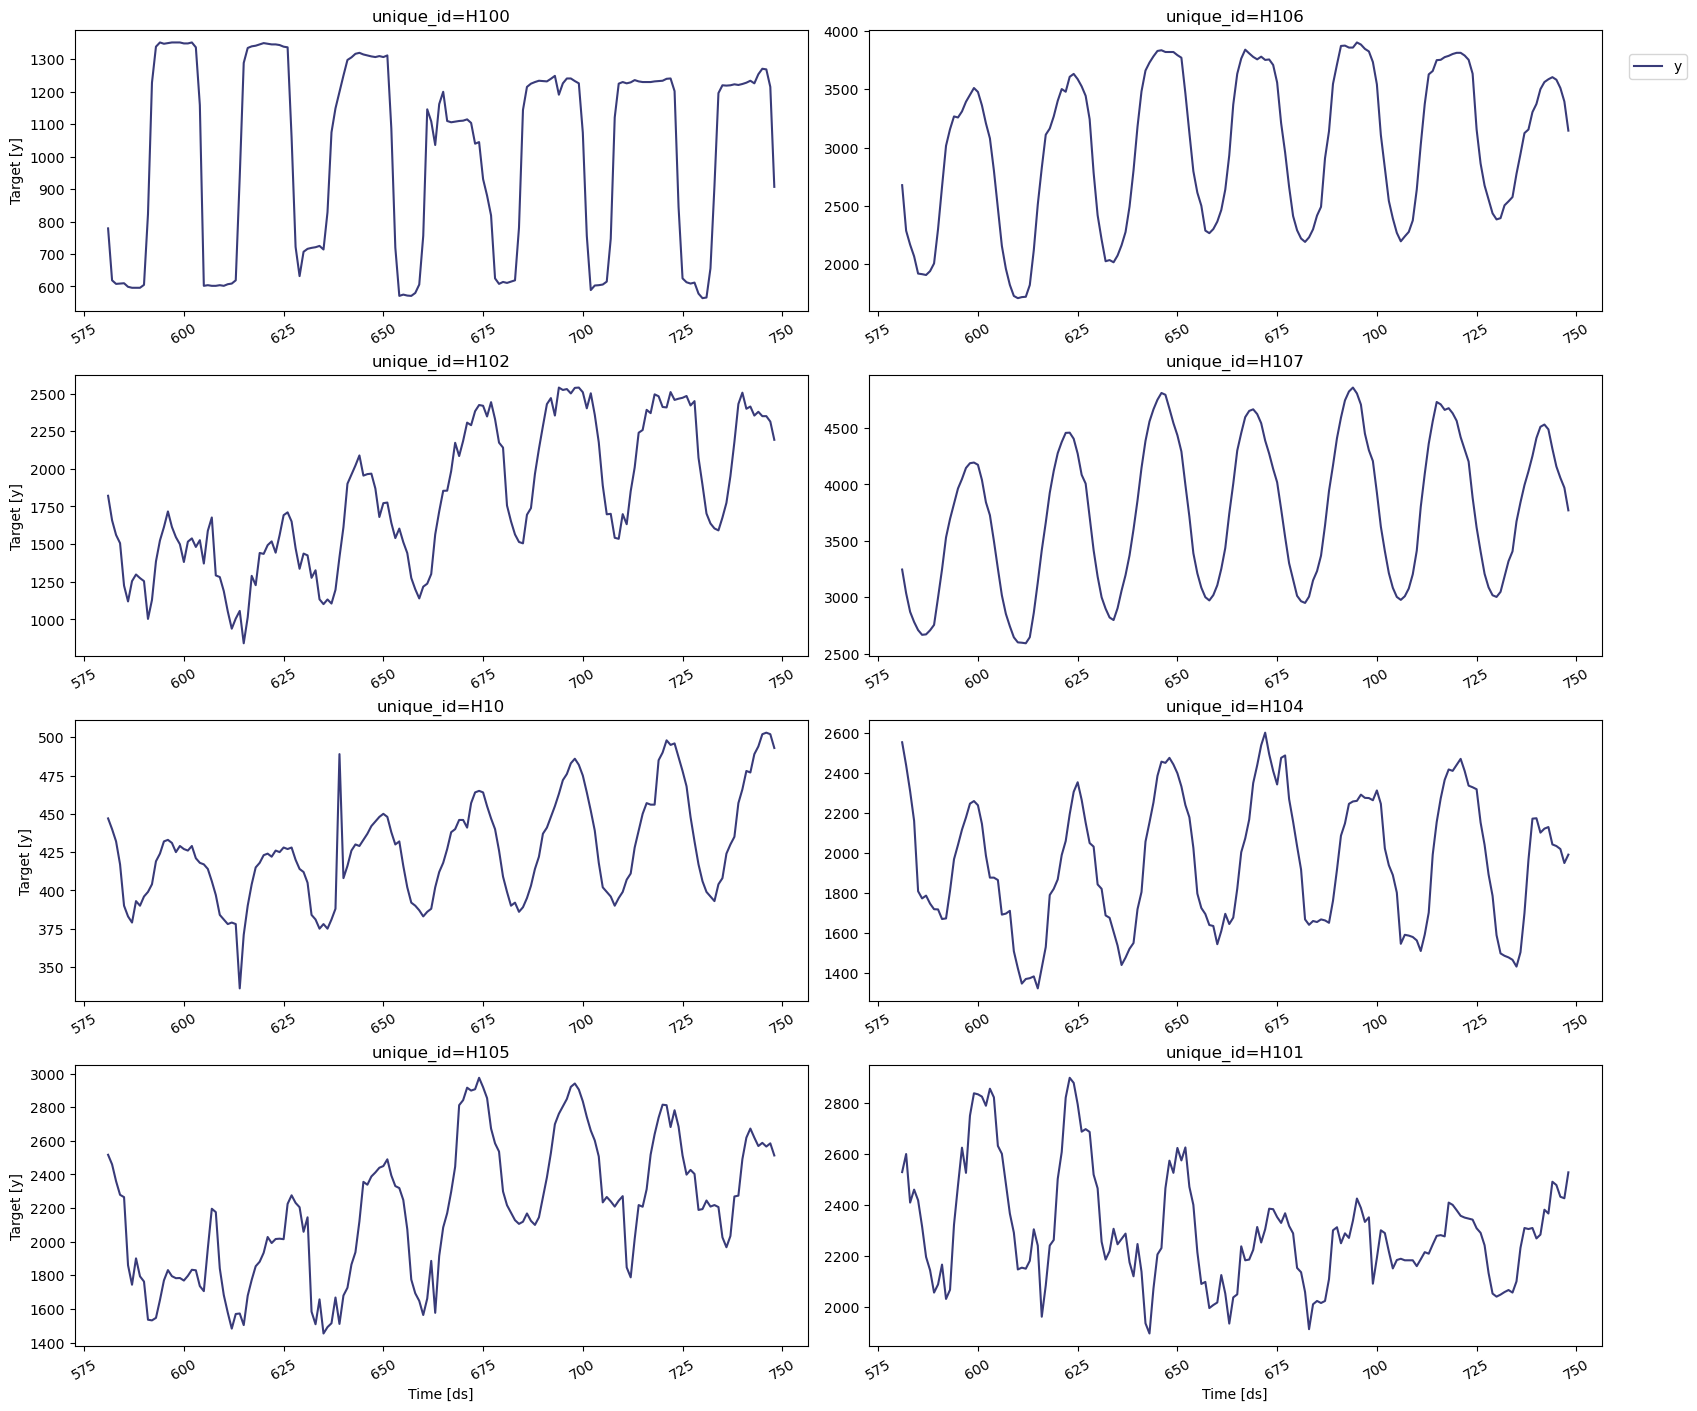

In [5]:
StatsForecast.plot(Y_df)

## Train Multiple Models for Many Series

StatsForecast can train many models on many time series efficiently. Start by importing and instantiating the desired models. StatsForecast offers a wide variety grouped into categories such as:

- Auto Forecast (automatic variants of ARIMA, ETS, Theta, CES).
- Exponential Smoothing (SES, Holt-Winters, SSO).
- Benchmark models (Mean, Naive, Random Walk).
- Intermittent or Sparse models (Croston, ADIDA, IMAPA).
- Multiple Seasonalities (MSTL and related models).
- Theta models (Theta, DynamicTheta, etc.).

For this example we will use:

- `HoltWinters`: triple exponential smoothing for series with trend and seasonality.
- `CrostonClassic`: suited for intermittent series.
- `SeasonalNaive`: memory-efficient seasonal naive predictions.
- `HistoricAverage`: arithmetic mean baseline.
- `DynamicOptimizedTheta`: a performant theta-family model.

Setting the `season_length` argument is sometimes tricky—Rob Hyndman's article on seasonal periods is a helpful reference.

In [6]:
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
)

In [7]:
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
]
models

[HoltWinters,
 CrostonClassic,
 SeasonalNaive,
 HistoricAverage,
 DynamicOptimizedTheta]

### Instantiate StatsForecast

Fit the models by creating a `StatsForecast` object with:

- `models`: list of instantiated models.
- `freq`: frequency of the data (see pandas frequency strings or integers).
- `n_jobs`: number of jobs used for parallel processing (`-1` for all cores).
- `fallback_model`: a model to use if another model fails during fitting.

`StatsForecast` achieves its speed via Numba JIT compilation. The first fit may take a few seconds; subsequent runs will be faster once the functions are compiled.

In [8]:
sf = StatsForecast(
    models=models,
    freq=1,
    fallback_model=SeasonalNaive(season_length=7),
    n_jobs=1,  # single-core execution keeps the walkthrough compatible with ipynb conversion
)
sf

StatsForecast(models=[HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta])

### Generate Forecasts

The `forecast` method accepts:

- `h`: forecast horizon (number of steps ahead).
- `level`: list of confidence levels for prediction intervals.

The result is a data frame with point forecasts, lower/upper bounds, and one column per model. Depending on your machine this step should take about a minute (remove auto models for faster demos).

`StatsForecast.forecast` is compatible with distributed clusters and does not store model parameters. For parameter persistence use `fit` + `predict`, keeping in mind that some distributed engines may not support those methods.

In [9]:
forecasts_df = sf.forecast(df=Y_df, h=48, level=[90])
forecasts_df.head()

,unique_id,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
0,H1,749,829.0,422.549268,1235.450732,829.0,422.549268,1235.450732,635.0,566.036734,703.963266,660.982143,398.037761,923.926524,592.701851,577.677300,611.652642
1,H1,750,807.0,400.549268,1213.450732,807.0,400.549268,1213.450732,572.0,503.036734,640.963266,660.982143,398.037761,923.926524,525.589117,505.449706,546.621821
2,H1,751,785.0,378.549268,1191.450732,785.0,378.549268,1191.450732,532.0,463.036734,600.963266,660.982143,398.037761,923.926524,489.251814,462.072830,512.424107
3,H1,752,756.0,349.549268,1162.450732,756.0,349.549268,1162.450732,493.0,424.036734,561.963266,660.982143,398.037761,923.926524,456.195032,430.554311,478.260966
4,H1,753,719.0,312.549268,1125.450732,719.0,312.549268,1125.450732,477.0,408.036734,545.963266,660.982143,398.037761,923.926524,436.290514,411.051209,461.815996


## Visualize Forecasts

Plot the results of eight random series using `StatsForecast.plot`.

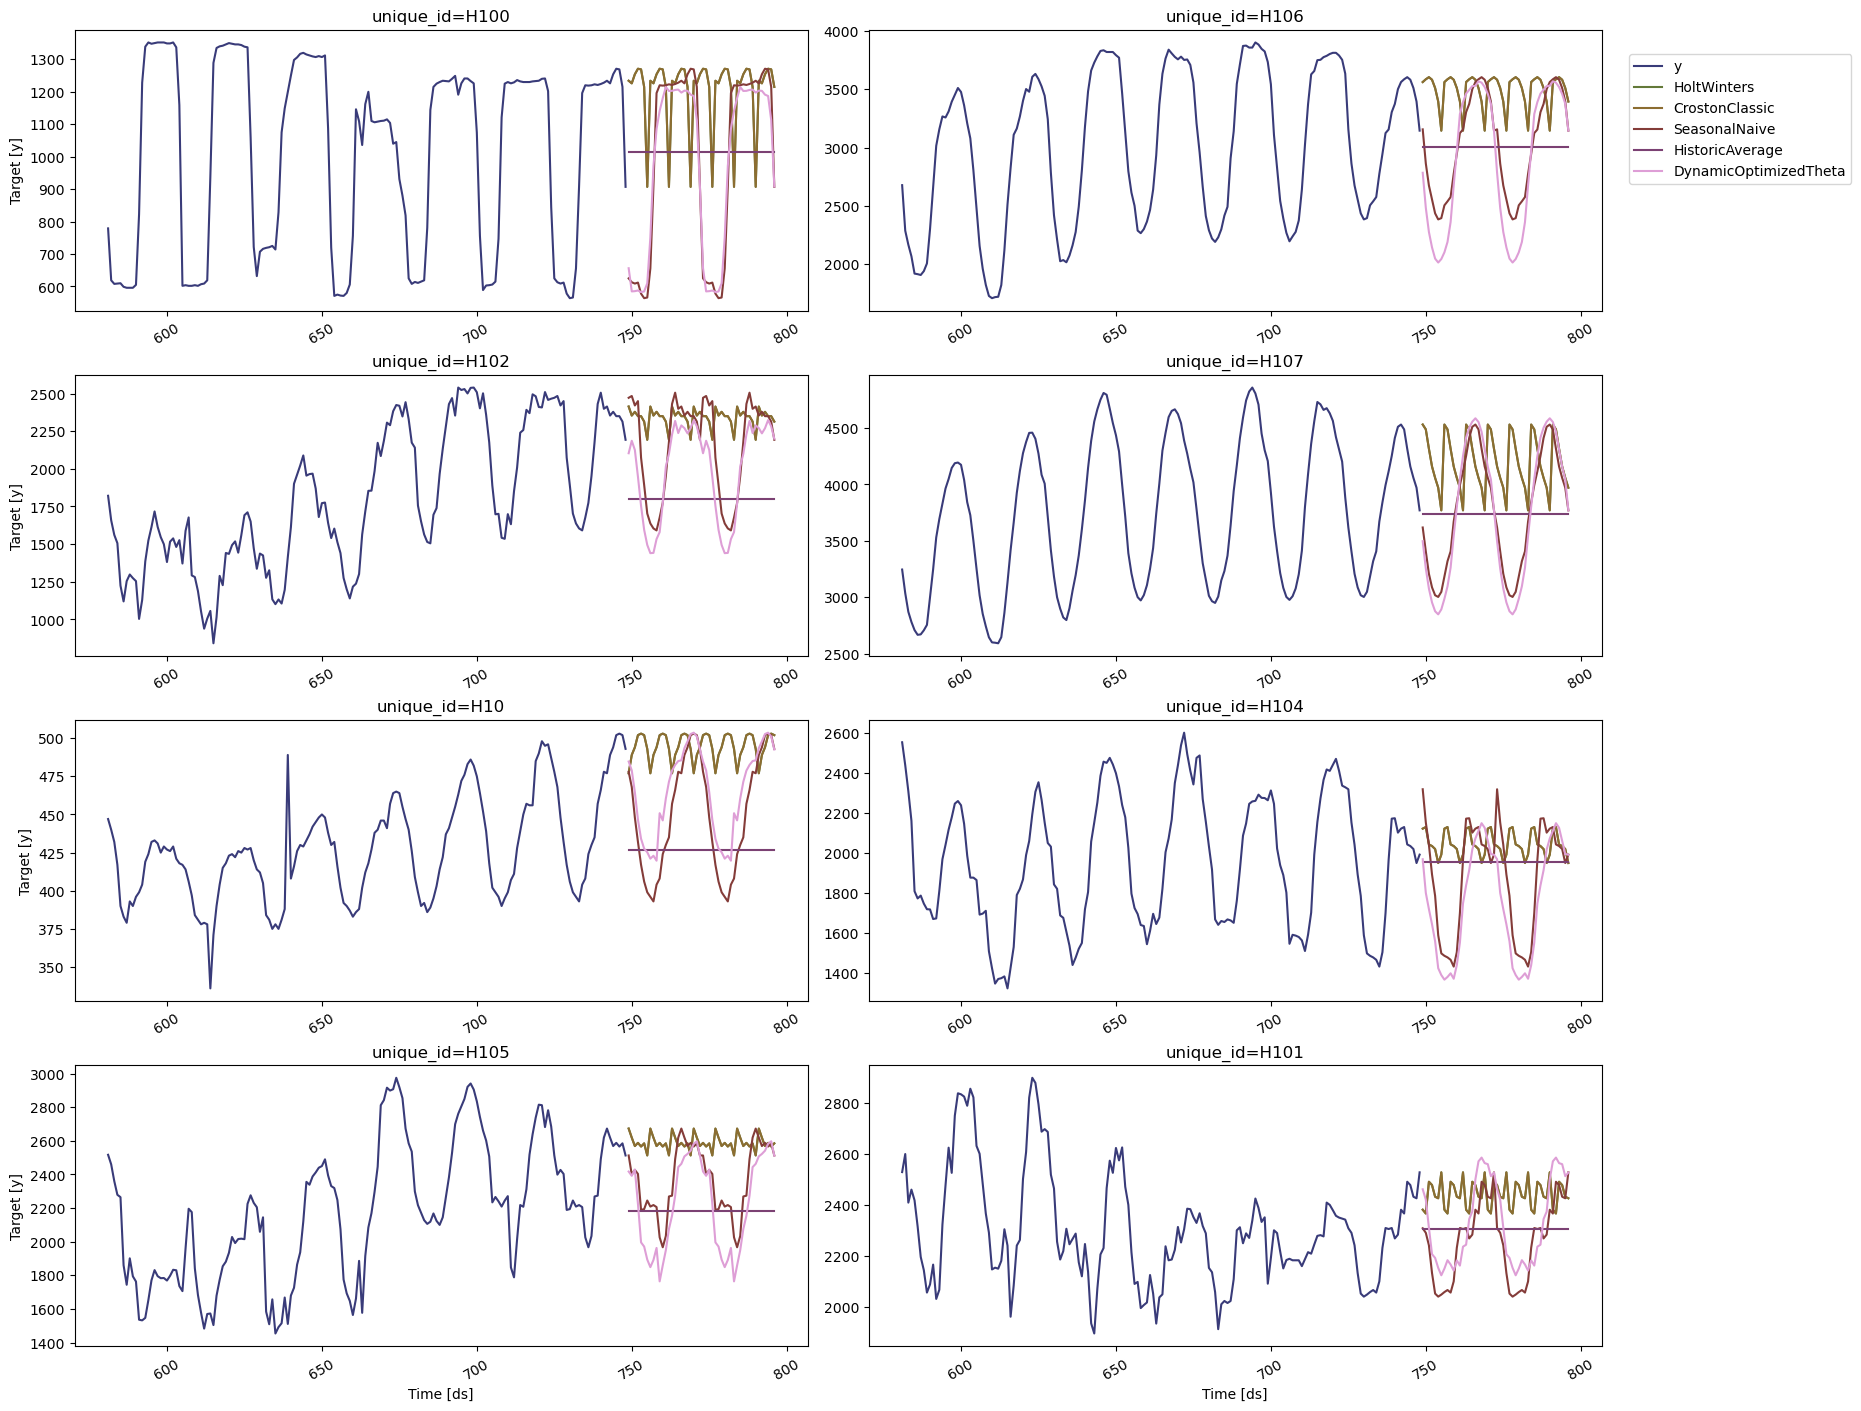

In [10]:
sf.plot(Y_df, forecasts_df)

The plotting helper allows further customization. For example, restrict to selected models or specific `unique_id` values.

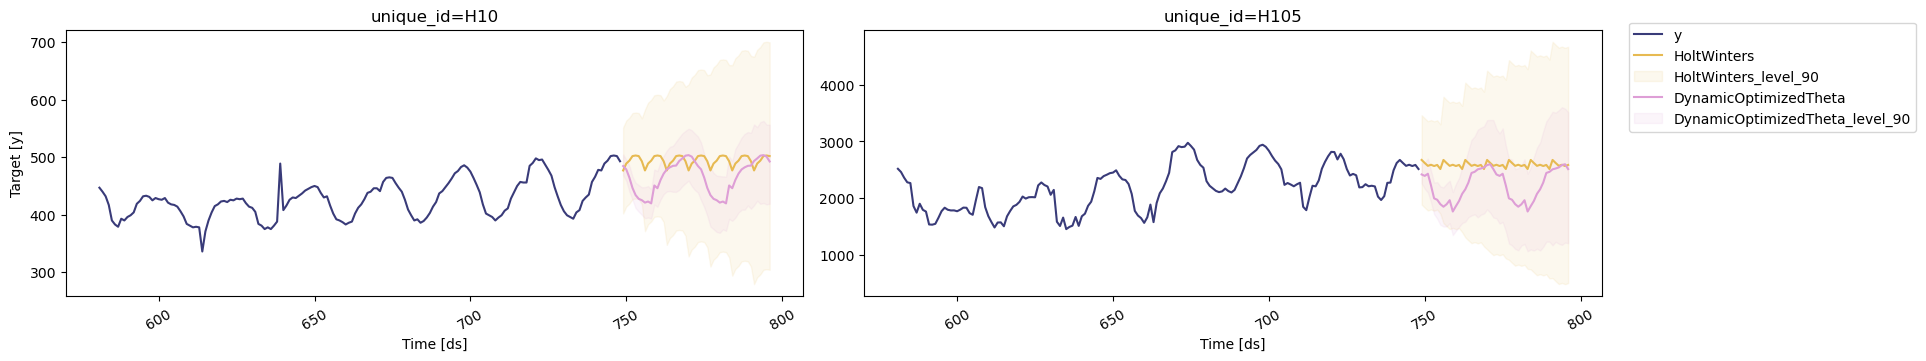

In [11]:
sf.plot(
    Y_df,
    forecasts_df,
    models=["HoltWinters", "DynamicOptimizedTheta"],
    unique_ids=["H10", "H105"],
    level=[90],
)

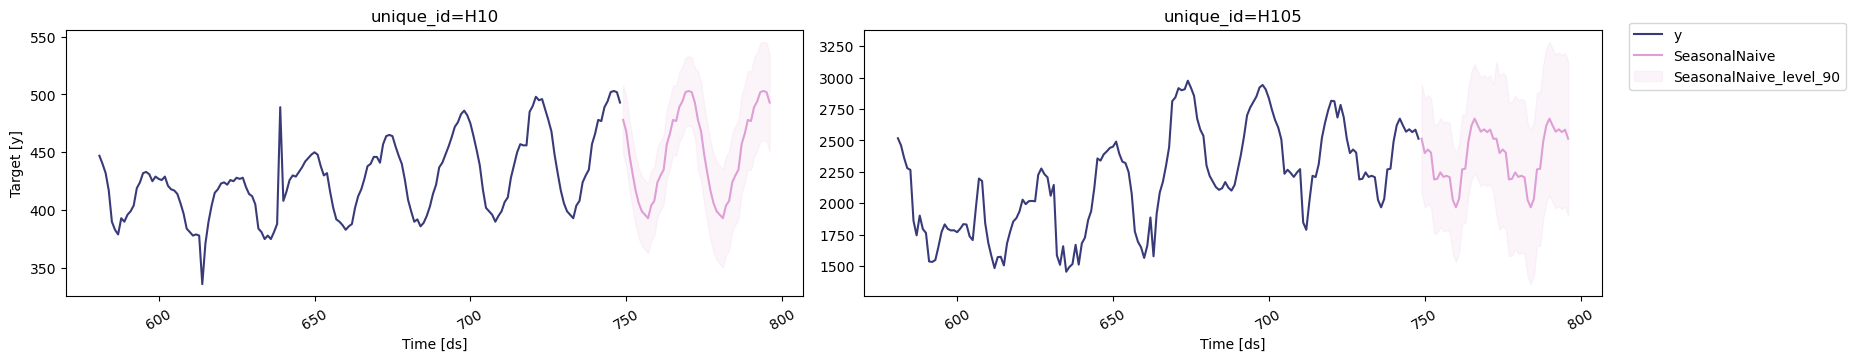

In [12]:
# Explore other models
sf.plot(Y_df, forecasts_df, models=["SeasonalNaive"], unique_ids=["H10", "H105"], level=[90])

## Evaluate Model Performance

To assess accuracy and robustness, perform time-series cross-validation. Define a sliding window across the historical data and predict the period following it. This mirrors how the model would have performed in the past while keeping training data contiguous.

With time series data, cross validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model's predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

![Chained Windows](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

In this case we evaluate the last two days (`n_windows=2`) forecasting every second day (`step_size=24`). Setting `n_windows=1` mirrors a traditional train/test split.

`StatsForecast.cross_validation` arguments:

- `df`: training data frame.
- `h`: forecast horizon.
- `step_size`: window shift.
- `n_windows`: number of windows to evaluate.

In [13]:
cv_df = sf.cross_validation(
    df=Y_df,
    h=24,
    step_size=24,
    n_windows=2,
)
cv_df.head()

,unique_id,ds,cutoff,y,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta
0,H1,701,700,619.0,847.0,742.668748,691.0,661.675,612.767525
1,H1,702,700,565.0,820.0,742.668748,618.0,661.675,536.846296
2,H1,703,700,532.0,790.0,742.668748,563.0,661.675,497.824302
3,H1,704,700,495.0,784.0,742.668748,529.0,661.675,464.723235
4,H1,705,700,481.0,752.0,742.668748,504.0,661.675,440.972351


The cross-validation data frame includes:

- `unique_id`: series identifier.
- `ds`: timestamp or temporal index.
- `cutoff`: last timestamp used for each window.
- `y`: actual value.
- One column per model containing fitted values.

Next, evaluate performance using error metrics such as Mean Absolute Error (MAE) or Mean Squared Error (MSE). The helper below computes an evaluation table and highlights the best model per series.

Note: MAPE can be misleading for granular data, so MSE or MAE are often preferred.

In [14]:
from utilsforecast.losses import mse

In [15]:
def evaluate_cv(df, metric):
    models_cols = df.columns.drop(["unique_id", "ds", "y", "cutoff"]).tolist()
    evals = metric(df, models=models_cols)
    evals["best_model"] = evals[models_cols].idxmin(axis=1)
    return evals


In [16]:
evaluation_df = evaluate_cv(cv_df, mse)
evaluation_df.head()

,unique_id,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,best_model
0,H1,44888.020833,28038.733985,1422.666667,20927.664488,1296.333117,DynamicOptimizedTheta
1,H10,2812.916667,1483.483839,96.895833,1980.367543,379.631699,SeasonalNaive
2,H100,121625.375000,91945.139237,12019.000000,78491.191439,21699.646799,SeasonalNaive
3,H101,28453.395833,16183.634340,10944.458333,18208.409800,63698.059884,SeasonalNaive
4,H102,232924.854167,132655.309136,12699.895833,309110.475212,31393.070741,SeasonalNaive


Create a summary table counting how many series each model wins.

In [17]:
evaluation_df["best_model"].value_counts().to_frame().reset_index()

,best_model,count
0,SeasonalNaive,6
1,DynamicOptimizedTheta,4


You can also inspect unique IDs where a specific model performs best and visualize those forecasts.

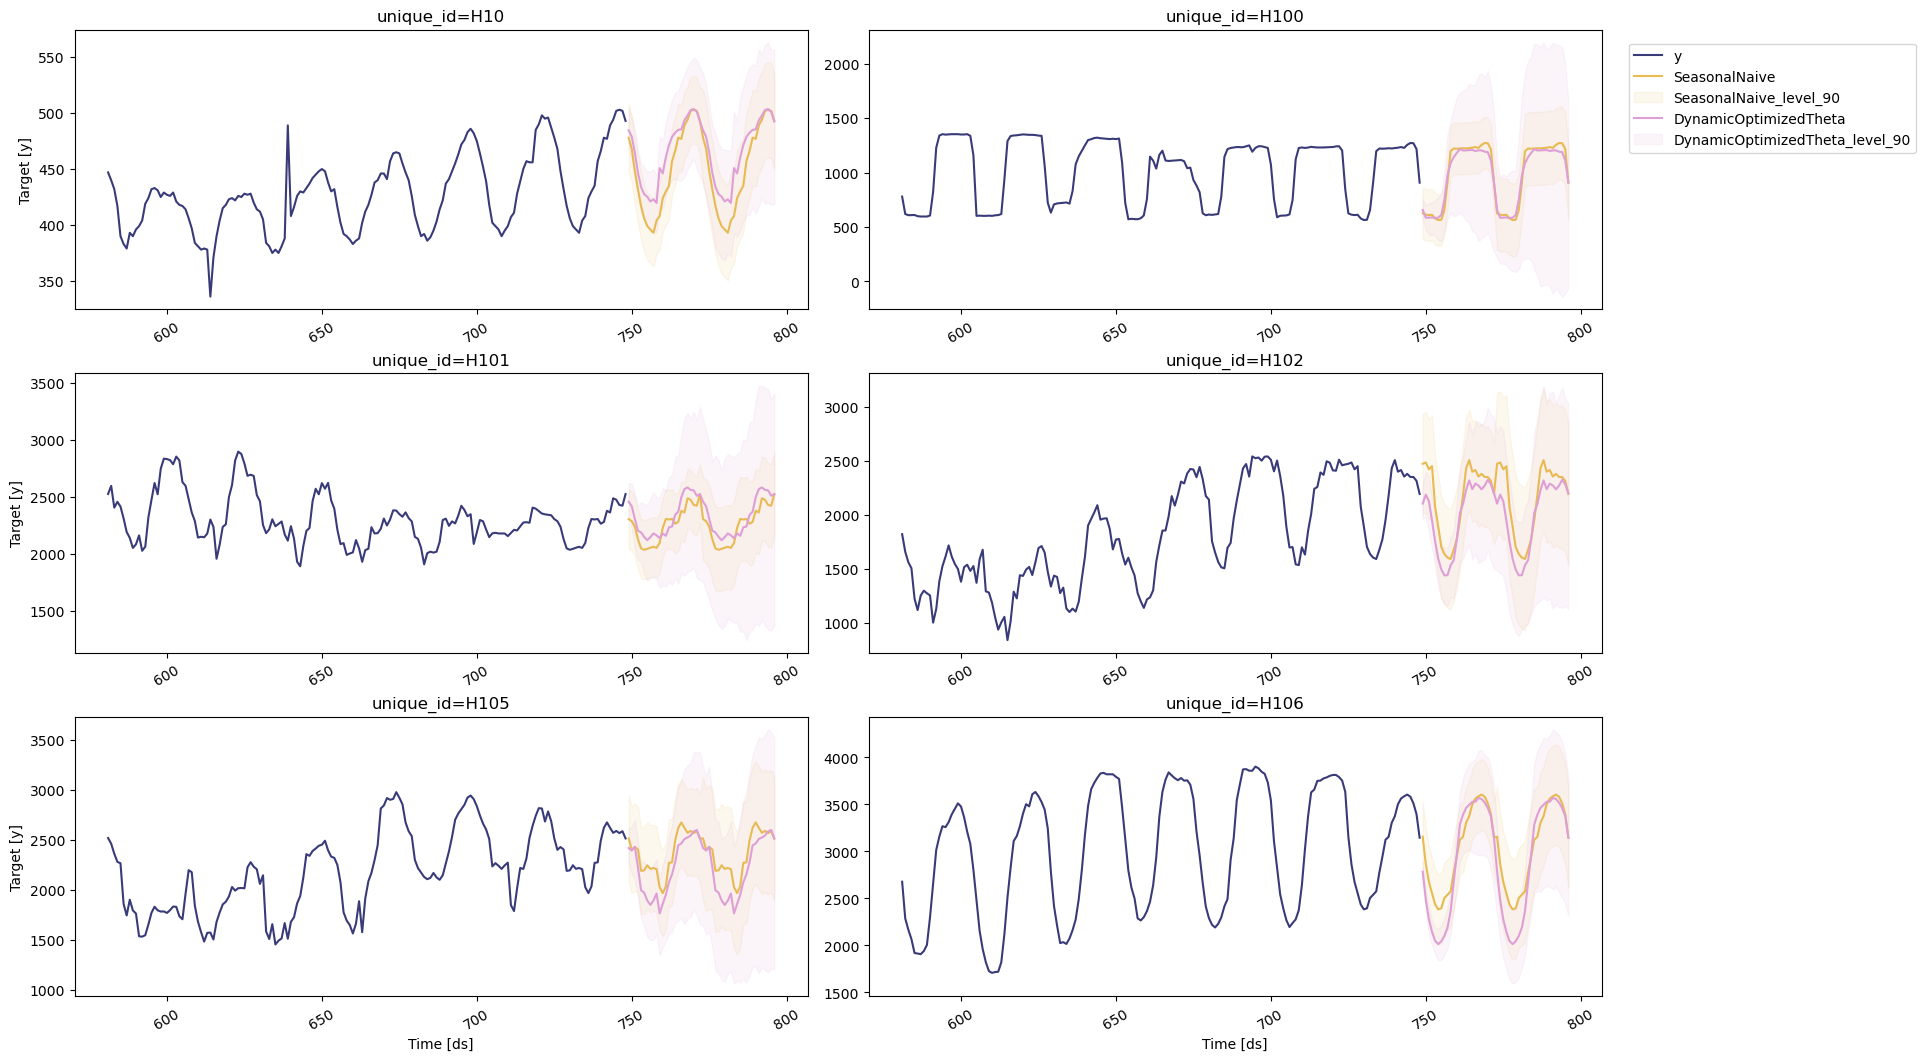

In [18]:
seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"')["unique_id"]
sf.plot(Y_df, forecasts_df, unique_ids=seasonal_ids, models=["SeasonalNaive", "DynamicOptimizedTheta"], level=[90])

## Select the Best Model for Every Series

Define a utility function that merges the cross-validation results with the forecast data frame and extracts the best-performing forecast (including intervals) per `unique_id`.

In [19]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    with_best = forecasts_df.merge(evaluation_df[["unique_id", "best_model"]])
    result = with_best[["unique_id", "ds"]].copy()
    for suffix in ("", "-lo-90", "-hi-90"):
        result[f"best_model{suffix}"] = with_best.apply(
            lambda row: row[row["best_model"] + suffix], axis=1
        )
    return result


In [20]:
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)
prod_forecasts_df.head()

,unique_id,ds,best_model,best_model-lo-90,best_model-hi-90
0,H1,749,592.701851,577.677300,611.652642
1,H1,750,525.589117,505.449706,546.621821
2,H1,751,489.251814,462.072830,512.424107
3,H1,752,456.195032,430.554311,478.260966
4,H1,753,436.290514,411.051209,461.815996


Plot the production-ready forecast table to confirm the selected models behave as expected.

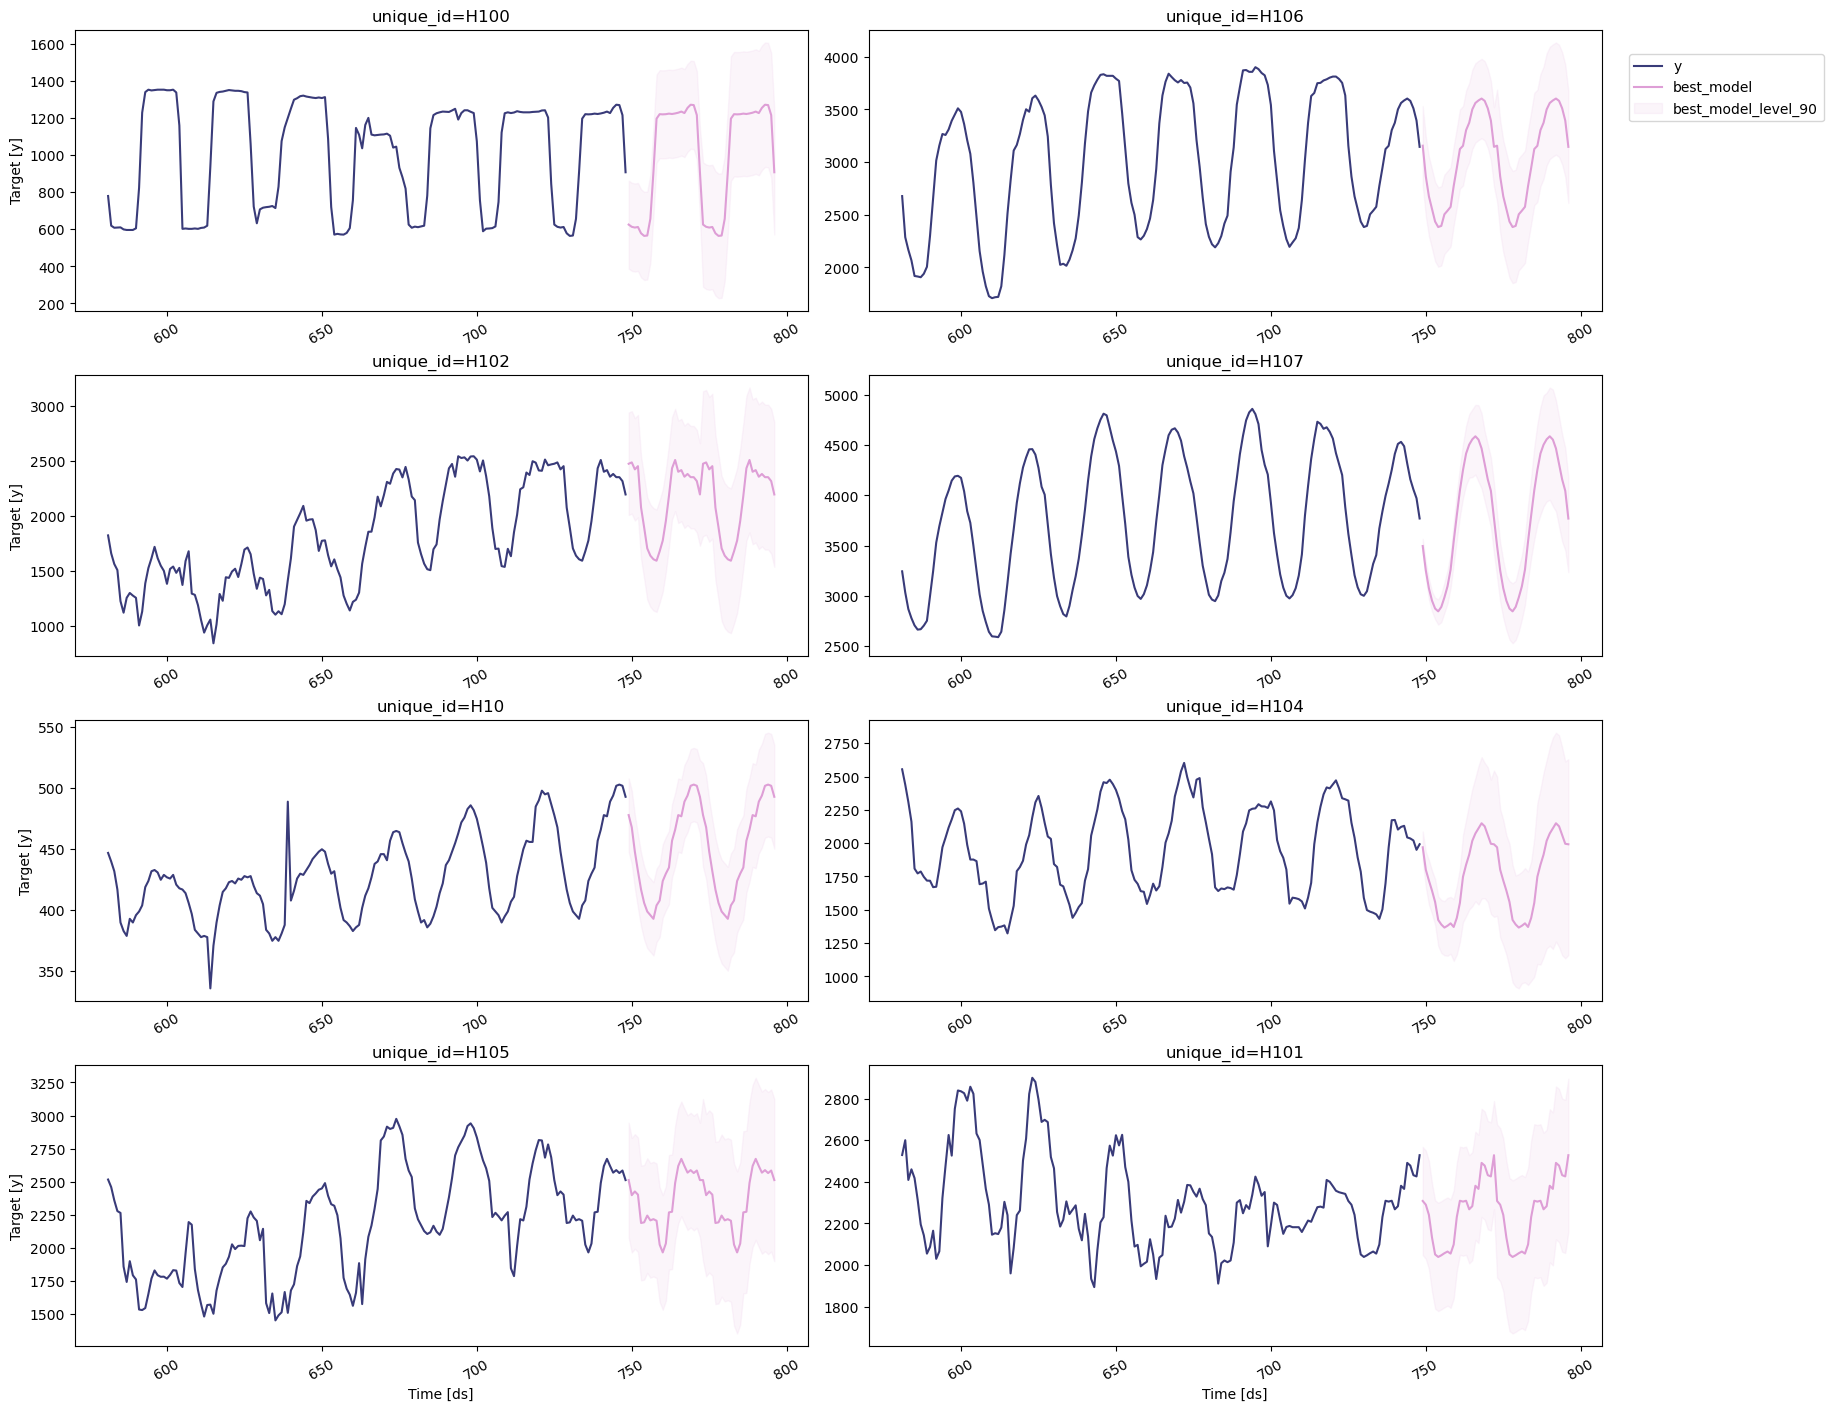

In [21]:
sf.plot(Y_df, prod_forecasts_df, level=[90])
